In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## Procesamiento de datos

In [12]:
ruta_datasets = 'data/'

In [13]:
dataset_sube = pd.read_csv(ruta_datasets+'sube-2023.csv')
dataset_sube_regresion = pd.read_csv(ruta_datasets+'sube-2023-regresion.csv')

### Ejercicio 1

#### a)

Describimos el dataset

In [14]:
dataset_sube.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472291 entries, 0 to 472290
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   DIA_TRANSPORTE   472291 non-null  object
 1   NOMBRE_EMPRESA   472291 non-null  object
 2   LINEA            472291 non-null  object
 3   AMBA             472291 non-null  object
 4   TIPO_TRANSPORTE  472291 non-null  object
 5   JURISDICCION     469742 non-null  object
 6   PROVINCIA        469720 non-null  object
 7   MUNICIPIO        469720 non-null  object
 8   CANTIDAD         472291 non-null  int64 
 9   DATO_PRELIMINAR  472291 non-null  object
dtypes: int64(1), object(9)
memory usage: 36.0+ MB


Transformamos la columna dia_transporte a datetime

In [15]:
dataset_sube['DIA_TRANSPORTE'] = pd.to_datetime(dataset_sube['DIA_TRANSPORTE'], format='%Y-%m-%d')

#### b)

##### i.

Creamos la columna fecha_dia con el nombre del día de la semana

In [16]:
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
def obtener_nombre_dia(fecha_dia):
    return dias[fecha_dia.weekday()]

In [17]:
dataset_sube['FECHA_DIA'] = dataset_sube['DIA_TRANSPORTE'].apply(obtener_nombre_dia)

##### ii.

Creamos la columna fecha_ordinal donde asignamos el numero de día del año a cada fecha

In [18]:
dataset_sube['FECHA_ORDINAL'] = dataset_sube['DIA_TRANSPORTE'].dt.day_of_year

##### iii.

Creamos la columna fecha_mes con el numero de mes para cada fecha

In [19]:
dataset_sube['FECHA_MES'] = dataset_sube['DIA_TRANSPORTE'].dt.month

### Ejercicio 2

Creamos un dataframe que contiene solo los datos del AMBA y elimina los datos preliminares

In [20]:
datos_amba = dataset_sube[dataset_sube['AMBA']=='SI']
datos_amba = datos_amba[datos_amba['DATO_PRELIMINAR']=='NO']

Acomodamos el orden de las columnas y les corregimos el formato del nombre

In [21]:
datos_amba = datos_amba[['DIA_TRANSPORTE', 'FECHA_DIA', 'FECHA_MES','FECHA_ORDINAL', 'JURISDICCION', 'LINEA','CANTIDAD', 'TIPO_TRANSPORTE']]

In [22]:
datos_amba = datos_amba.rename(columns={"DIA_TRANSPORTE": "fecha", "FECHA_DIA": "fecha_dia","FECHA_MES" : "fecha_mes", "FECHA_ORDINAL":"fecha_ordinal","JURISDICCION": "jurisdiccion", "LINEA":'linea',"CANTIDAD":"pasajeros", "TIPO_TRANSPORTE": "tipo_transporte"})

Resultado final:

In [23]:
datos_amba.head()

,fecha,fecha_dia,fecha_mes,fecha_ordinal,jurisdiccion,linea,pasajeros,tipo_transporte
0,2023-01-01,Domingo,1,1,MUNICIPAL,1,61,COLECTIVO
1,2023-01-01,Domingo,1,1,MUNICIPAL,2B,11,COLECTIVO
3,2023-01-01,Domingo,1,1,PROVINCIAL,BS_AS_LINEA_326,438,COLECTIVO
5,2023-01-01,Domingo,1,1,MUNICIPAL,BS_AS_LINEA_514,3067,COLECTIVO
6,2023-01-01,Domingo,1,1,MUNICIPAL,BS_AS_LINEA_522,332,COLECTIVO


### Ejercicio 3

#### a)

Calculamos la proporcion de pasajeros por transporte en 2023

In [24]:
pasajeros_totales = sum(datos_amba['pasajeros'])

In [25]:
pasajeros_por_transporte = datos_amba.groupby('tipo_transporte')['pasajeros'].sum()

In [26]:
## ponerlo mas lindo. Signo %
proporcion_pasajeros = (pasajeros_por_transporte/pasajeros_totales)*100 
proporcion_pasajeros.round(1)

tipo_transporte
COLECTIVO    83.8
SUBTE         6.8
TREN          9.4
Name: pasajeros, dtype: float64

#### b)

Creamos un dataset con los datos del Subte, agrupamos por mes y linea, y obtenemos el valor maximo

In [27]:
datos_subte = datos_amba[datos_amba['tipo_transporte'] == 'SUBTE']
datos_subte = datos_subte[['fecha_mes','linea','pasajeros']]

In [28]:
datos_subte_mesLinea = datos_subte.groupby(['fecha_mes','linea'])['pasajeros'].sum()

In [29]:
mes_linea_maxPasajeros = pd.DataFrame(datos_subte_mesLinea).idxmax()

Tupla (mes, línea de subte) donde viajó la mayor cantidad de pasajeros

In [30]:
mes_linea_maxPasajeros.iloc[0]

(8, 'LINEA_B')

#### c)

Creamos el dataset solo con los días habiles, calculamos el desvío estandar para cada día y vemos el menor

In [31]:
dias_habiles = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes']
datos_amba_habiles = datos_amba[datos_amba['fecha_dia'].isin(dias_habiles)]

In [32]:
desvios = []
for dia_habil in dias_habiles:
    desvio_estandar = datos_amba_habiles[datos_amba_habiles['fecha_dia']==dia_habil]['pasajeros'].std().round(1)
    desvio_dia = (dia_habil, desvio_estandar)
    desvios.append(desvio_dia)
print(desvios)

[('Lunes', 33577.5), ('Martes', 35833.7), ('Miércoles', 35980.8), ('Jueves', 35968.3), ('Viernes', 35059.7)]


In [33]:
dia_menos_desvio = min(desvios, key=lambda x: x[1])
dia_menos_desvio[0]

'Lunes'

## Analisis exploratorio

### Ejercicio 4

- mediana, media, variacion, desvio estandar, promedio (.mean(), .std(), )
- cantidad de pasajeros por mes para cada transporte
- cantidad de pasajeros por provincia
- cantidad de pasajeros por año (sumar desde 2020)
- cantidad de pasajeros por municipio AMBA
- cantidad de pasajeros ?

In [34]:
dataset_sube[dataset_sube['CANTIDAD']<0]

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,FECHA_DIA,FECHA_ORDINAL,FECHA_MES
284929,2023-08-13,SOFSE- SARMIENTO,FFCC SAR MERLO - LOBOS,SI,TREN,NACIONAL,JN,SD,-25,NO,Domingo,225,8
284930,2023-08-13,SOFSE- SARMIENTO,FFCC SAR MORENO - MERCEDES,SI,TREN,NACIONAL,JN,SD,-1,NO,Domingo,225,8
284933,2023-08-13,SOFSE - Belgrano Sur,FFCC_BELG_SUR,SI,TREN,NACIONAL,JN,SD,-11,NO,Domingo,225,8
378164,2023-10-22,SOFSE - Belgrano Sur,FFCC_BELG_SUR,SI,TREN,NACIONAL,JN,SD,-1,NO,Domingo,295,10
387623,2023-10-29,SOFSE- SARMIENTO,FFCC SAR MERLO - LOBOS,SI,TREN,NACIONAL,JN,SD,-92,NO,Domingo,302,10
388788,2023-10-30,SOFSE- SARMIENTO,FFCC SAR MERLO - LOBOS,SI,TREN,NACIONAL,JN,SD,-417,NO,Lunes,303,10


<Axes: xlabel='fecha_mes', ylabel='pasajeros'>

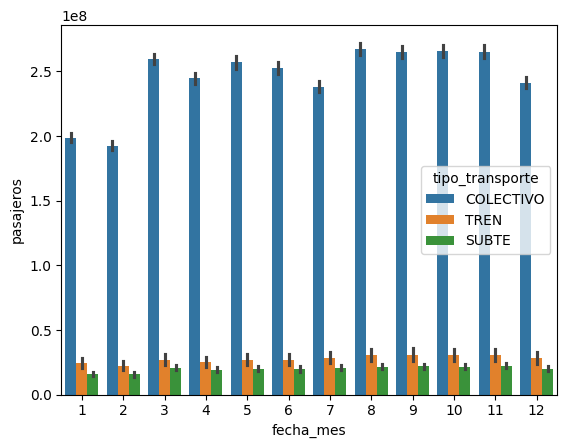

In [35]:
sns.barplot(data=datos_amba, x='fecha_mes', y='pasajeros', hue='tipo_transporte', estimator='sum')

<Axes: xlabel='fecha_mes', ylabel='pasajeros'>

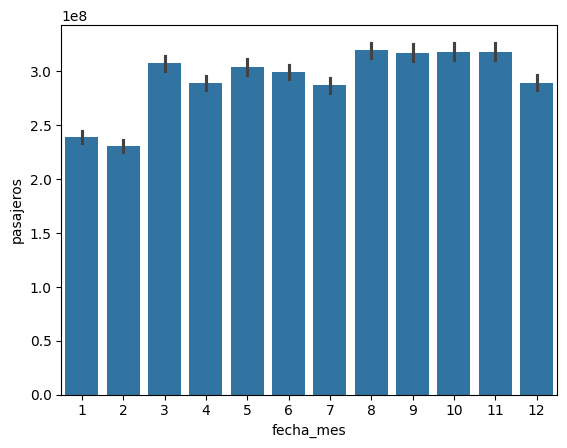

In [36]:
sns.barplot(data=datos_amba, x='fecha_mes', y='pasajeros', estimator='sum')

<Axes: xlabel='fecha_dia', ylabel='pasajeros'>

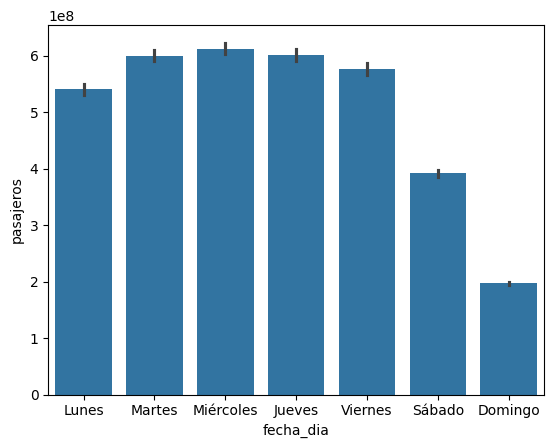

In [37]:
sns.barplot(data=datos_amba, x='fecha_dia', y='pasajeros', estimator='sum', order=dias)

In [100]:
pivot_table = datos_amba.pivot_table(
    values='pasajeros', 
    index='fecha_dia', 
    columns='tipo_transporte', 
    aggfunc='sum', 
    fill_value=0
)

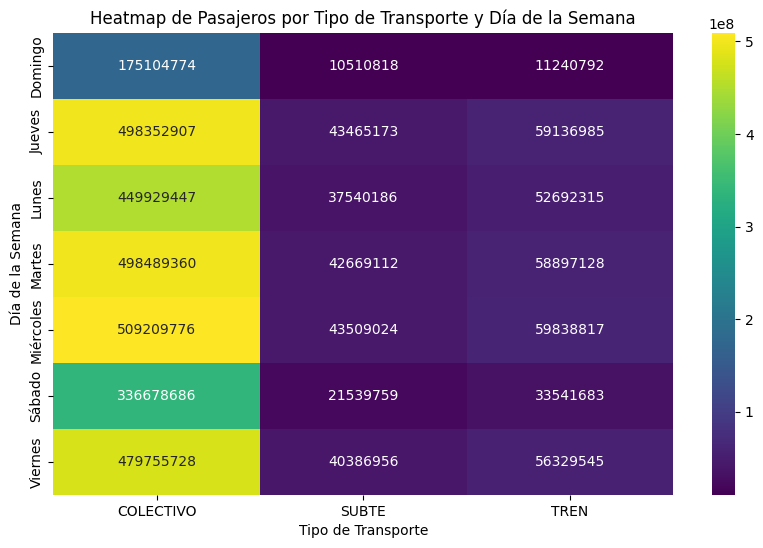

In [105]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='viridis')
plt.title('Heatmap de Pasajeros por Tipo de Transporte y Día de la Semana')
plt.xlabel('Tipo de Transporte')
plt.ylabel('Día de la Semana')
plt.show()

In [98]:
datos_amba.head()

,fecha,fecha_dia,fecha_mes,fecha_ordinal,jurisdiccion,linea,pasajeros,tipo_transporte
0,2023-01-01,Domingo,1,1,MUNICIPAL,1,61,COLECTIVO
1,2023-01-01,Domingo,1,1,MUNICIPAL,2B,11,COLECTIVO
3,2023-01-01,Domingo,1,1,PROVINCIAL,BS_AS_LINEA_326,438,COLECTIVO
5,2023-01-01,Domingo,1,1,MUNICIPAL,BS_AS_LINEA_514,3067,COLECTIVO
6,2023-01-01,Domingo,1,1,MUNICIPAL,BS_AS_LINEA_522,332,COLECTIVO


## Modelado

### Ejercicio 5

In [51]:
datos_ColectivoJN = dataset_sube_regresion[(dataset_sube_regresion['TIPO_TRANSPORTE']=='COLECTIVO') & (dataset_sube_regresion['PROVINCIA']=='JN') & (dataset_sube_regresion['AMBA']=='SI')]
cols = datos_ColectivoJN.LINEA.unique()

In [61]:
pasajeros_por_linea = pd.DataFrame()
for col in  cols:
    datos_linea = datos_ColectivoJN[datos_ColectivoJN.LINEA ==col][["DIA_TRANSPORTE", "CANTIDAD"]]
    datos_linea =datos_linea.set_index("DIA_TRANSPORTE").rename(columns ={"CANTIDAD" : col})
    pasajeros_por_linea = pd.concat([pasajeros_por_linea ,datos_linea], axis = 1)

In [63]:
pasajeros_por_linea = pasajeros_por_linea.dropna(axis=1)

In [70]:
pasajeros_por_linea.head()

,BS_ASLINEA_123,BSAS_LINEA_002,BSAS_LINEA_009,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_019,BSAS_LINEA_020,BSAS_LINEA_021,BSAS_LINEA_022,...,LINEA 4,LINEA 42,LINEA 44,LINEA 50,LINEA 6,LINEA 7,LINEA 76,LINEA 8,LINEA_099,LINEA_164_AMBA
DIA_TRANSPORTE,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1681,5670,5644,5177,9109,7013,1604,2617,11235,2202,...,2942,4029,4649,4839,2449,2184,3797,5317,1882,3210
2023-01-02,9440,21759,23284,21176,45269,29962,13921,11934,55611,13823,...,15329,19072,20387,16221,10486,12774,17374,23250,10322,19362
2023-01-04,10540,24755,25405,23806,52873,33659,16172,13366,61721,16206,...,17836,21609,23595,18448,12193,13949,19860,26294,11981,21784
2023-01-05,10408,25772,26489,24688,53436,35182,16569,12929,62510,16863,...,18044,21993,23687,18481,12888,14668,21235,27216,11787,22972
2023-01-06,10530,26021,26458,24167,53163,35212,16459,12955,63528,16846,...,18122,22421,23731,19300,12703,14199,23472,27073,11567,23411


In [106]:
pasajeros_por_linea_5 = pasajeros_por_linea[['BSAS_LINEA_002','BS_ASLINEA_123','BSAS_LINEA_010','BSAS_LINEA_015','BSAS_LINEA_017']]

In [107]:
pasajeros_por_linea_5

,BSAS_LINEA_002,BS_ASLINEA_123,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_009
DIA_TRANSPORTE,,,,,,
2023-01-01,5670,1681,5177,9109,7013,5644
2023-01-02,21759,9440,21176,45269,29962,23284
2023-01-04,24755,10540,23806,52873,33659,25405
2023-01-05,25772,10408,24688,53436,35182,26489
2023-01-06,26021,10530,24167,53163,35212,26458
...,...,...,...,...,...,...
2023-12-22,35664,15957,31803,65544,47601,26684
2023-12-23,24236,8844,19964,43408,31986,19188
2023-12-27,29591,12721,29374,60347,41283,24693


In [110]:
X=pasajeros_por_linea
y=pasajeros_por_linea[['BSAS_LINEA_009']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [111]:

modelo = linear_model.LinearRegression() 
modelo.fit(X=X_train, y=y_train)

LinearRegression()

In [114]:
y_pred = modelo.predict(X_test)

In [115]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 1.823385657113916e-20
R-squared: 1.0


In [116]:
y_pred

array([[30168.],
       [12303.],
       [29848.],
       [35358.],
       [11746.],
       [37494.],
       [11855.],
       [37410.],
       [16891.],
       [36381.],
       [ 9906.],
       [21027.],
       [13743.],
       [27806.],
       [21177.],
       [14330.],
       [38729.],
       [26836.],
       [21643.],
       [26214.],
       [24693.],
       [26356.],
       [34219.],
       [11437.],
       [36218.],
       [33175.],
       [35516.],
       [24355.],
       [27258.],
       [33948.],
       [37887.],
       [18517.],
       [27858.],
       [10518.],
       [28982.],
       [20020.],
       [24865.],
       [38387.],
       [33814.],
       [ 9391.],
       [ 8850.],
       [13283.],
       [34262.],
       [21844.],
       [36655.],
       [34402.],
       [34606.],
       [19741.],
       [14829.],
       [ 6525.]])

In [119]:
y_test = y_test.values.reshape(-1)
y_pred = y_pred.reshape(-1)

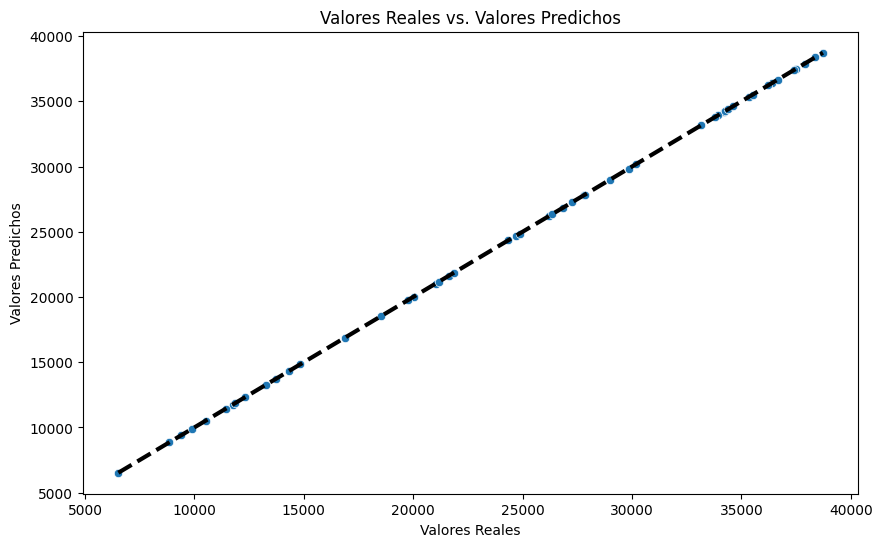

In [121]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs. Valores Predichos')
plt.show()